<a href="https://colab.research.google.com/github/fabjenny13/traffic_classifier/blob/main/ImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SETUP AND LOAD DATA

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.7.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.1
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-iers-data                     0.2025.5.26.0.

In [1]:
import tensorflow as tf
import os #used to navigate through file structures

In [ ]:
#Limiting memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
#remove dodgy images
import cv2
import imghdr

images_path = "drive/MyDrive/images"
img_exts = ['jpeg', 'jpg', 'png', 'bmp']

for image_class in os.listdir(images_path):
  for image in os.listdir(os.path.join(images_path, image_class)):
    img_path = os.path.join(images_path, image_class, image)
    try:
      img = cv2.imread(img_path)
      tip = imghdr.what(img_path)
      if tip not in img_exts:
        print("Image not in ext list: {}".format(img_path))
        os.remove(img_path)
    except Exception as e:
      print("Issue with image: {}".format(img_path))
      #os.remove(img_path)


<ipython-input-3-e1fe2c3dc490>:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#loading data
data = tf.keras.utils.image_dataset_from_directory("drive/MyDrive/images", image_size = (224, 224), batch_size = 32) #building a data pipeline

Found 1454 files belonging to 13 classes.


In [ ]:
data_iterator = data.as_numpy_iterator() #data isn't loaded into memory. It's sort of generated on the fly, which is why we need to access this way.
#batch = data_iterator.next() #accessing a batch

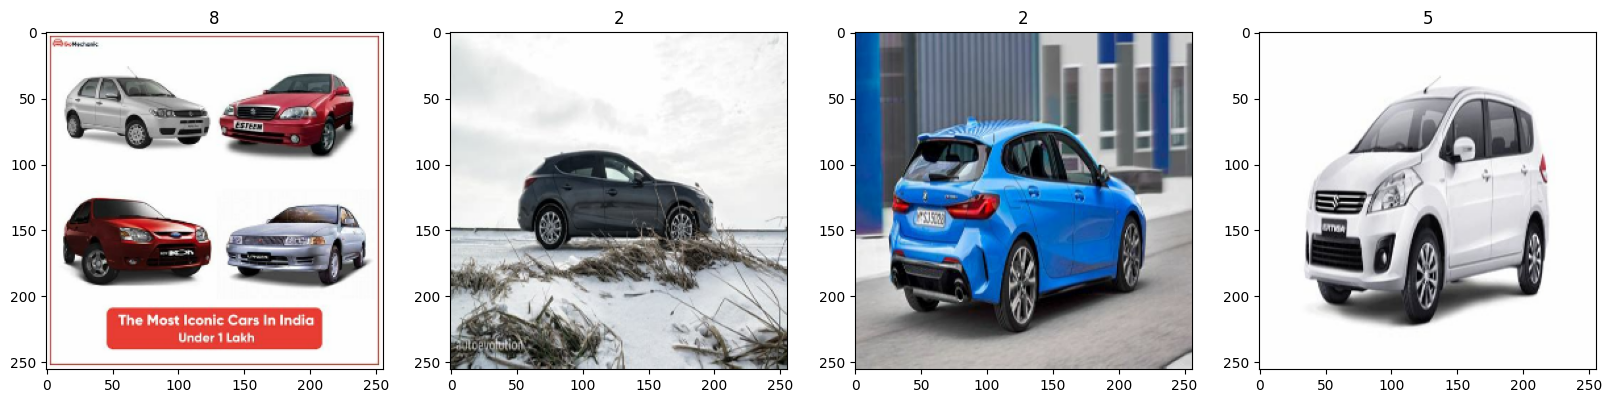

In [ ]:
batch = data_iterator.next()
#batch[1] #labels
#batch[0] #images represented as numpy array


fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])


*VEHICLE LABELS*

0 BICYCLE

1 BUS

2 HATCHBACK

3 LCV

4 MINI BUS

5 MUV

6 OTHERS

7 SUV

8 SEDAN

9 TEMPO TRAVELLER

10 TRUCK

11 TWO WHEELER

12 VAN



PREPROCESSING DATA

In [4]:
#scale data
data = data.map(lambda x, y: (x/255, y))

# Shuffle and split
data = data.shuffle(1000)
data_size = data.cardinality().numpy()


VEHICLES = ["Bicycle", "Bus", "Hatchback", "LCV", "Mini Bus", "MUV", "Others", "SUV", "Sedan", "Tempo Traveller", "Truck", "Two Wheeler", "Van"]

In [29]:
#split data
train_size = int(len(data) * 0.7);
val_size = int(len(data) * 0.2);
test_size = int(len(data) * 0.1);

train = data.take(train_size);
val = data.skip(train_size).take(val_size);
test = data.skip(train_size + val_size).take(test_size);

BUILDING THE DEEP LEARNING MODEL

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [7]:

# Load pretrained MobileNetV2 as feature extractor
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze pretrained layers

# Build classifier on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(13, activation='softmax')
])

model.compile('adam', loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), 1, activation = 'relu', input_shape = (256, 256, 3))) #no. of filters, size of filters, stride
                                                                                  #relu converts negative values to 0
model.add(BatchNormalization())
model.add(MaxPooling2D())


model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))  # try 0.3 or 0.5
model.add(Dense(13, activation = 'softmax'))



model.compile('adam', loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 842,989 (3.22 MB)

 Trainable params: 842,733 (3.21 MB)

 Non-trainable params: 256 (1.00 KB)

In [8]:
#train model
logdir = "drive/MyDrive/logs";
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs') #logs to keeps track of progress
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


hist = model.fit(train, epochs = 15, validation_data=val, callbacks = [tensorboard_callback, early_stop] )

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 506s 571ms/step - accuracy: 0.3508 - loss: 2.0240 - val_accuracy: 0.7014 - val_loss: 0.9083
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.6955 - loss: 0.9164 - val_accuracy: 0.8299 - val_loss: 0.5366
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.7331 - loss: 0.7200 - val_accuracy: 0.8507 - val_loss: 0.4806
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 338ms/step - accuracy: 0.8291 - loss: 0.5698 - val_accuracy: 0.8778 - val_loss: 0.3725
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 361ms/step - accuracy: 0.8397 - loss: 0.4866 - val_accuracy: 0.9097 - val_loss: 0.3222
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.8674 - loss: 0.3977 - val_accuracy: 0.9236 - val_loss: 0.2857
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.8630 - loss: 0.4081 - val_accuracy: 0.9407 - val_loss: 0.2795
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 271ms/step - accuracy: 0.8914 - loss: 0.3239 - val_acc

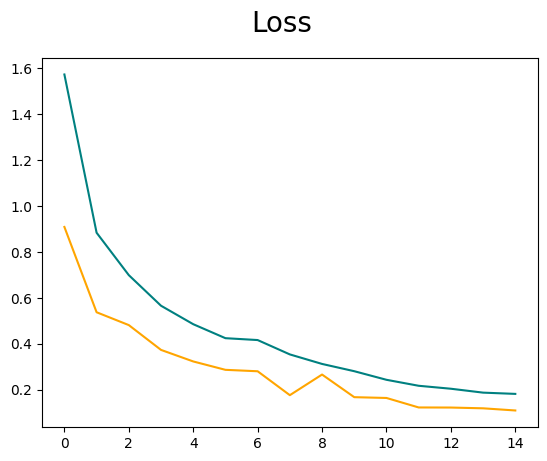

In [9]:
#plot performance
fig = plt.figure()
plt.plot(hist.history['loss'], color = "teal", label = "loss")
plt.plot(hist.history['val_loss'], color = "orange", label = "val_loss")
fig.suptitle("Loss", fontsize = 20)
plt.show()

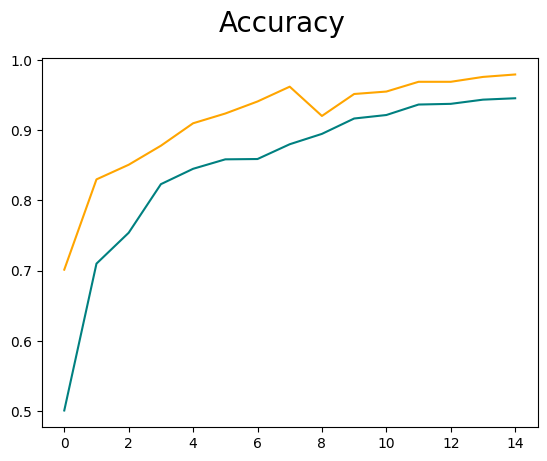

In [10]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], label = "accuracy", color = "teal")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy", color = "orange")
fig.suptitle("Accuracy", fontsize = 20)
plt.show()

EVALUATE PERFORMANCE

In [11]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

precision = Precision()
acc = Accuracy()
recall = Recall()

for batch in test.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  y_pred_classes = [np.argmax(element) for element in y_pred]
  precision.update_state(y, y_pred_classes)
  acc.update_state(y, y_pred_classes)
  recall.update_state(y, y_pred_classes)

print("Precision: ", precision.result().numpy())
print("Accuracy: ", acc.result().numpy())
print("Recall: ", recall.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Precision:  1.0
Accuracy:  0.984375
Recall:  1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
[np.int64(11), np.int64(6), np.int64(6), np.int64(10), np.int64(9), np.int64(2), np.int64(0), np.int64(1), np.int64(6), np.int64(3), np.int64(4), np.int64(6), np.int64(1), np.int64(6), np.int64(6), np.int64(7), np.int64(2), np.int64(0), np.int64(0), np.int64(4), np.int64(7), np.int64(9), np.int64(7), np.int64(6), np.int64(2), np.int64(2), np.int64(6), np.int64(4), np.int64(9), np.int64(10), np.int64(9), np.int64(9)]


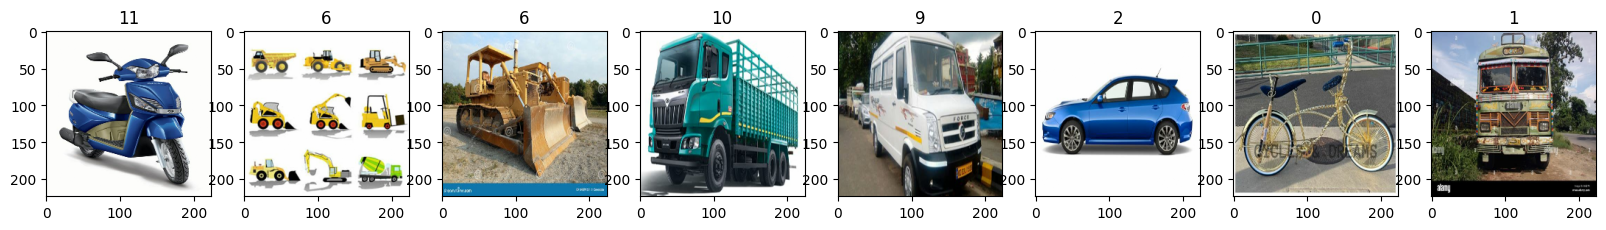

In [31]:
batch = test.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols = 8, figsize = (20, 20))

for idx, img in enumerate(batch[0][:8]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])
X, y = batch

y_pred = model.predict(X)
y_pred_class = [np.argmax(ele) for ele in y_pred]
print(y_pred_class)

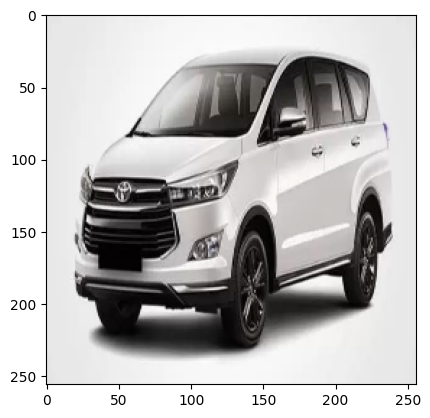

In [34]:

#test
import cv2

img = cv2.imread("drive/MyDrive/test_images/muvtest.jpg")
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [35]:
y_pred = model.predict(np.expand_dims(resize/255, 0))
result = np.argmax(y_pred)
print(VEHICLES[result])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
MUV


SAVE MODEL

In [22]:
from tensorflow.keras.models import load_model

In [23]:
model.save(os.path.join("drive/MyDrive/models", "mobileNetV2_Model.h5"))

In [ ]:
model = load_model(os.path.join("drive/MyDrive/models", "Indian_Vehicle_Classifier.h5"))
y_pred = model.predict(np.expand_dims(resize/255, 0))
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
[[0.05172109]]
Predicted: MUV
